In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [16]:
# Convert dates to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [17]:
customers

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15
...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07
196,C0197,Christina Harvey,Europe,2023-03-21
197,C0198,Rebecca Ray,Europe,2022-02-27
198,C0199,Andrea Jenkins,Europe,2022-12-03


In [18]:
data = pd.merge(customers, transactions, on='CustomerID')

In [19]:
data.isna().sum()

CustomerID         0
CustomerName       0
Region             0
SignupDate         0
TransactionID      0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

In [29]:
data

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64
...,...,...,...,...,...,...,...,...,...,...
995,C0200,Kelly Cross,Asia,2023-06-11,T00518,P034,2024-12-11 03:05:50,4,868.20,217.05
996,C0200,Kelly Cross,Asia,2023-06-11,T00091,P057,2024-04-27 19:06:20,1,239.70,239.70
997,C0200,Kelly Cross,Asia,2023-06-11,T00731,P061,2024-07-15 20:36:28,4,627.84,156.96
998,C0200,Kelly Cross,Asia,2023-06-11,T00771,P048,2024-09-10 09:50:48,4,1665.60,416.40


In [60]:
# Aggegrate invoice data
invoice_data = data.groupby('CustomerID').TransactionID.agg(**{ 'total_transactions' : 'nunique' })

In [43]:
sale_data = data.groupby('CustomerID').TotalValue.agg(**{
    'Total_Sales' : 'sum',
    'Avg_prodduct_value': 'mean'
}
)

In [42]:
customer_features

,Total_Sales,Avg_prodduct_value
CustomerID,,
C0001,3354.52,670.904000
C0002,1862.74,465.685000
C0003,2725.38,681.345000
C0004,5354.88,669.360000
C0005,2034.24,678.080000
...,...,...
C0196,4982.88,1245.720000
C0197,1928.65,642.883333
C0198,931.83,465.915000


In [45]:
# Aggregate product data
product_data = data.groupby('CustomerID').ProductID.agg( **{ 'total_products' : 'count', 
                                                     'total_unique_products' : 'nunique' } )

In [46]:
product_data

,total_products,total_unique_products
CustomerID,,
C0001,5,5
C0002,4,4
C0003,4,4
C0004,8,8
C0005,3,3
...,...,...
C0196,4,3
C0197,3,3
C0198,2,2


In [49]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = data.groupby(['CustomerID' , 'TransactionID']).TotalValue.agg( **{ 'cart_value' : 'sum' })
cart_data

cart_value
CustomerID TransactionID            
C0001      T00015             114.60
           T00085             614.94
           T00436            1300.92
           T00445             911.44
           T00932             412.62
...                              ...
C0200      T00091             239.70
           T00518             868.20
           T00731             627.84
           T00771            1665.60
           T00889            1357.26

[1000 rows x 1 columns]

In [50]:
# Reset index
cart_data.reset_index(inplace=True)

In [52]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').cart_value.agg( **{ 'avg_cart_value' : 'mean', 
                                                                 'min_cart_value' : 'min',
                                                                 'max_cart_value' : 'max'})


In [53]:
agg_cart_data

,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
C0001,670.904000,114.60,1300.92
C0002,465.685000,254.72,770.74
C0003,681.345000,122.36,1385.20
C0004,669.360000,293.70,1099.76
C0005,678.080000,319.20,861.18
...,...,...,...
C0196,1245.720000,417.37,1669.48
C0197,642.883333,456.80,1013.73
C0198,465.915000,26.99,904.84


In [61]:
# Join together customer-level data
customer_df = invoice_data.join([product_data, sale_data, agg_cart_data])
customer_df

,total_transactions,total_products,total_unique_products,Total_Sales,Avg_prodduct_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
C0001,5,5,5,3354.52,670.904000,670.904000,114.60,1300.92
C0002,4,4,4,1862.74,465.685000,465.685000,254.72,770.74
C0003,4,4,4,2725.38,681.345000,681.345000,122.36,1385.20
C0004,8,8,8,5354.88,669.360000,669.360000,293.70,1099.76
C0005,3,3,3,2034.24,678.080000,678.080000,319.20,861.18
...,...,...,...,...,...,...,...,...
C0196,4,4,3,4982.88,1245.720000,1245.720000,417.37,1669.48
C0197,3,3,3,1928.65,642.883333,642.883333,456.80,1013.73
C0198,2,2,2,931.83,465.915000,465.915000,26.99,904.84


In [78]:
# Normalize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_df.reset_index().drop(columns=['CustomerID'], axis=1))


StandardScaler()

In [87]:
# Apply KMeans clustering
n_clusters = 4  # Adjust based on experimentation
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_features['cluster'] = kmeans.fit_predict(scaled_data)

,Total_Sales,Avg_prodduct_value,cluster,pca1,pca2
CustomerID,,,,,
C0001,3354.52,670.904000,1,0.044888,-0.332741
C0002,1862.74,465.685000,1,-1.815855,-1.009509
C0003,2725.38,681.345000,1,-0.625832,0.082308
C0004,5354.88,669.360000,0,2.072816,-0.963594
C0005,2034.24,678.080000,1,-1.956068,0.470153
...,...,...,...,...,...
C0196,4982.88,1245.720000,3,0.813324,3.640361
C0197,1928.65,642.883333,1,-1.988486,0.705721
C0198,931.83,465.915000,2,-3.009362,-0.809973


In [80]:
# Clustering metrics
db_index = davies_bouldin_score(scaled_data, customer_features['cluster'])
sil_score = silhouette_score(scaled_data, customer_features['cluster'])

In [81]:
db_index

1.0185563044447612

In [90]:
# Dimensionality reduction for visualization (PCA)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)
customer_features['TotalSales'] = pca_components[:, 0]
customer_features['Avg_product_value'] = pca_components[:, 1]

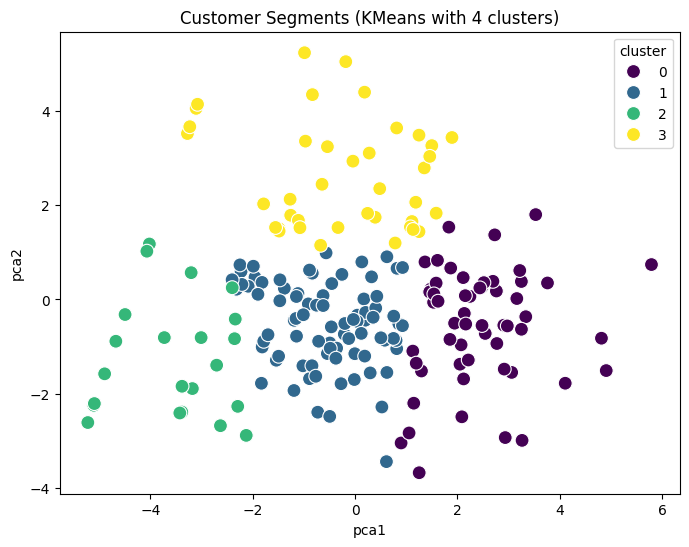

Number of clusters: 4
DB Index: 1.0185563044447612
Silhouette Score: 0.30878006751551623


In [95]:
# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=customer_features, palette='viridis', s=100)
plt.title(f'Customer Segments (KMeans with {n_clusters} clusters)')
plt.show()

# Report results
print(f"Number of clusters: {n_clusters}")
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {sil_score}")